In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
# %matplotlib qt5
%matplotlib inline

In [3]:
data_test = pd.read_csv('./cs-test.csv',index_col=0)

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(6)
memory usage: 9.3 MB


In [8]:
data_train = pd.read_csv('./cs-training.csv',index_col=0)

In [9]:
data_train.columns.sort_values()

Index(['DebtRatio', 'MonthlyIncome', 'NumberOfDependents',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines',
       'SeriousDlqin2yrs', 'age'],
      dtype='object')

In [10]:
col_replace = {'SeriousDlqin2yrs':'target', ## 违约客户及超过90天逾期客户，bool型；
            'RevolvingUtilizationOfUnsecuredLines':'percentage', ## 贷款以及信用卡可用额度与总额度比例，百分比；
           'NumberOfOpenCreditLinesAndLoans':'open_loan', ## 开放式信贷和贷款数量，开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量，整型；
           'NumberOfTimes90DaysLate':'90-', ## 90天逾期次数：借款者有90天或更高逾期的次数，整型；
           'NumberRealEstateLoansOrLines':'estate_loan', ## 不动产贷款或额度数量：抵押贷款和不动产放款包括房屋净值信贷额度，整型；
           'NumberOfTime60-89DaysPastDueNotWorse':'60-89', ## 60-89天逾期但不糟糕次数，整型；
           'NumberOfDependents':'Dependents', ## 家属数量：不包括本人在内的家属数量，整型；
           'NumberOfTime30-59DaysPastDueNotWorse':'30-59' ## 35-59天逾期但不糟糕次数，整型；
              }
data_train.rename(columns=col_replace,inplace=True)

In [11]:
data_train.head()

,target,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [12]:
data_train.info() ## 说明只有两项有缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
target           150000 non-null int64
percentage       150000 non-null float64
age              150000 non-null int64
30-59            150000 non-null int64
DebtRatio        150000 non-null float64
MonthlyIncome    120269 non-null float64
open_loan        150000 non-null int64
90-              150000 non-null int64
estate_loan      150000 non-null int64
60-89            150000 non-null int64
Dependents       146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


## 重复值

In [13]:
data_train.duplicated().sum()

609

In [14]:
data_train.drop_duplicates(inplace=True)

## 缺失值

In [15]:
data_train.loc[data_train.MonthlyIncome.isna(),'Dependents'].isna().mean()

0.13100167687621916

In [16]:
data_train.loc[data_train.Dependents.isna(),'MonthlyIncome'].isna().mean() ## 结果1，说明家属没填的，月收入都没填。

1.0

In [17]:
data_train.dropna(subset=['Dependents'],inplace=True) ## 去掉两项都缺的项。

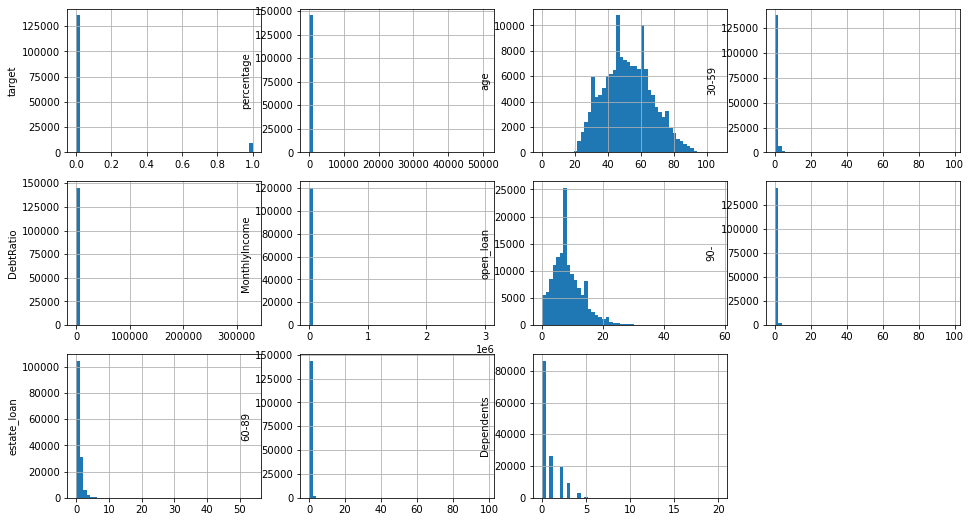

In [18]:
## 考察其他项有什么特征
plt.figure(figsize=(16,9))
for i,col in enumerate(data_train.columns):
    plt.subplot(3,4,i+1)
    data_train[col].hist(bins=50)
    plt.ylabel(col)

(array([ 7830., 19028., 24132., 21627., 14975., 11265.,  7993.,  4405.,
         2623.,  1762.]),
 array([    0. ,  1599.9,  3199.8,  4799.7,  6399.6,  7999.5,  9599.4,
        11199.3, 12799.2, 14399.1, 15999. ]),
 <a list of 10 Patch objects>)

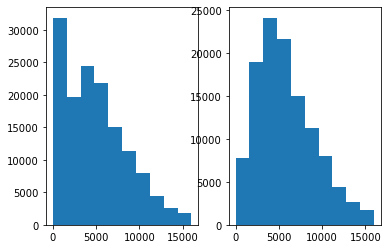

In [38]:
## 填充缺失值
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import KNNImputer
miss_imputer = IterativeImputer(ExtraTreesRegressor(10),initial_strategy="most_frequent",max_iter=5)
# miss_imputer2 = KNNImputer()
data_train_bak = data_train.copy()
data_train_bak.iloc[:,:-1]=miss_imputer.fit_transform(X=data_train.iloc[:,:-1])

plt.subplot(121)
plt.hist(data_train_bak.loc[data_train_bak.MonthlyIncome<16000,'MonthlyIncome'])
plt.subplot(122)
plt.hist(data_train.loc[data_train.MonthlyIncome<16000,'MonthlyIncome'])
## 填充结果改变了数据分布，不采用。

In [19]:
## 有缺失值的两列均改用未缺失项随机抽样填充
fill_len = data_train.MonthlyIncome.isna().sum()
data_train.loc[data_train.MonthlyIncome.isna(),'MonthlyIncome']=\
np.random.choice(data_train.loc[data_train.MonthlyIncome.notna(),'MonthlyIncome'],fill_len,False)

In [20]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145563 entries, 1 to 150000
Data columns (total 11 columns):
target           145563 non-null int64
percentage       145563 non-null float64
age              145563 non-null int64
30-59            145563 non-null int64
DebtRatio        145563 non-null float64
MonthlyIncome    145563 non-null float64
open_loan        145563 non-null int64
90-              145563 non-null int64
estate_loan      145563 non-null int64
60-89            145563 non-null int64
Dependents       145563 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.3 MB


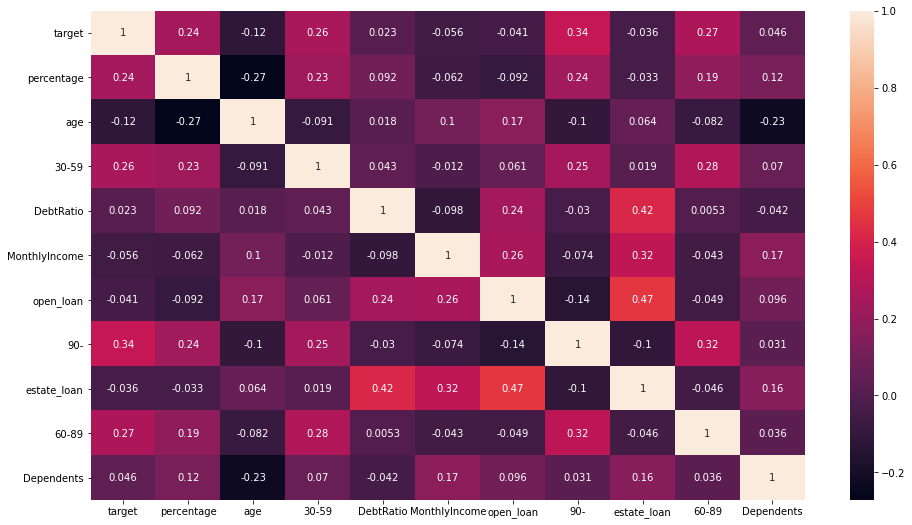

In [41]:
plt.figure(figsize=(16,9))
sns.heatmap(data_train.corr(method='spearman'),annot=True)
## 无>0.5的相关性, 暂不考虑降维

In [21]:
## 特征工程前，重置索引
data_train.reset_index(drop=True, inplace=True)

## 划分训练集验证集

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df_train, df_test = train_test_split(data_train,stratify=data_train.target)

## 自定分箱 卡方分箱 spearman分箱

In [24]:
import scipy

In [25]:
def init_box(df,n_split):
    ## 待份变量等频初始化分箱，统计分箱后标签频数
    categ = pd.cut(df.iloc[:,0],n_split,duplicates='raise')
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq.iloc[:,0] = freq.iloc[:,0].astype(object)

    ## 计算WOE,IV
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    
    return freq.set_index(freq.columns[0]), iv ## reindex方便后续计算

In [26]:
def mychi2(freq):
    R = freq.sum(1,keepdims=True)
    C = freq.sum(0)
    N = R.sum()
    E = R*C / N
    sqr = np.square(freq-E)/E
    sqr[E==0] = 0
    return sqr.sum()

In [27]:
chi2 = lambda x: scipy.stats.chi2_contingency(x,correction=False)[1]
add = lambda in1,in2: pd.Interval(in1.left,in2.right)
def chi2_box(df, n_split=20, p_thr=.05):
    '''
    df:两列，第一列是待分箱变量，第二列是标签
    n_split: 初始划分区间数
    p_thr: 拒绝概率
    '''
    ## 待份变量等频初始化分箱，统计分箱后标签频数
    categ = pd.qcut(df.iloc[:,0],n_split,duplicates='drop')
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq.iloc[:,0] = freq.iloc[:,0].astype(object)
    
    ## 相邻箱计算p值
    while True:
        p_val = [chi2(freq.iloc[i:i+2,1:]) for i in range(len(freq))]
        p_max = np.argmax(p_val[:-1])
        if p_val[p_max] <= p_thr:
            break
        freq.iloc[p_max,0] = add(freq.iloc[p_max,0], freq.iloc[p_max+1,0])
        freq.iloc[p_max,1:] = freq.iloc[p_max,1:] + freq.iloc[p_max+1,1:]
        freq.drop(index=freq.index[p_max+1],inplace=True)
    freq.iloc[-1,0] = add(freq.iloc[-1,0], pd.Interval(0,np.inf)) ## 适配数据
    freq.iloc[0,0] = add(pd.Interval(-np.inf,0), freq.iloc[0,0]) ## 适配数据

    ## 计算WOE,IV
    freq['p_val'] = p_val
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    
    return freq.set_index(freq.columns[0]),iv
    

(y                0     1          p_val       woe
 age                                              
 (-inf, 9.0]   8959  1041  1.064260e-253 -1.761470
 (9.75, 29.0]  7033  2967  2.021165e-209 -0.472055
 (29.5, 44.0]  4890  5110  2.058930e-168  0.435014
 (44.25, inf]  2979  7021   1.000000e+00  1.248325,
 1.0359061045755893)

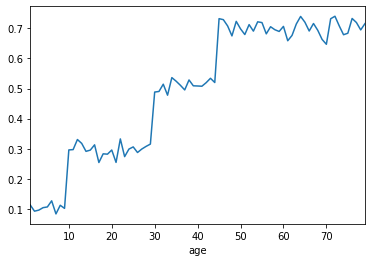

In [28]:
## test function 

num = 10000  ##构造一个有40000数据量的数据
x1 = np.random.randint(1,10,num)
x2 = np.random.randint(10,30,num)
x3 = np.random.randint(30,45,num)
x4 = np.random.randint(45,80,num)
x = np.r_[x1,x2,x3,x4]

y1 = np.random.choice([0,1],num,p=[.9,.1])
y2 = np.random.choice([0,1],num,p=[.7,.3])
y3 = np.random.choice([0,1],num,p=[.5,.5])
y4 = np.random.choice([0,1],num,p=[.3,.7])
y = np.r_[y1,y2,y3,y4]

testdata = pd.DataFrame({"age":x,"y":y})
testdata.groupby('age')['y'].mean().plot()
chi2_box(testdata,100,.001)

In [29]:
spearman = lambda x: scipy.stats.spearmanr(x.iloc[:,0], x.iloc[:,1])[0]
def spearman_box(df, n = 20, r_thr=1):
    r = 0
    while np.abs(r) < r_thr:
        categ = pd.qcut(df.iloc[:,0], n, duplicates='drop')
        d2 = df.groupby(categ).mean()
        r = spearman(d2)
        n = n - 1
    freq = pd.crosstab(categ, df.iloc[:,1]).reset_index()
    freq['woe'] = np.log(freq[1]/freq[0]*freq[0].sum()/freq[1].sum())
    iv = freq.woe.dot((freq[1]/freq[1].sum()-freq[0]/freq[0].sum()))
    return freq.set_index(freq.columns[0]),iv

target,0,1,p_val,woe
age,,,,
"(-inf, 35.0]",13924,1752,4.429449e-10,0.552320
"(35.0, 43.0]",15602,1562,6.392961e-09,0.323744
"(43.0, 55.0]",29499,2426,1.201356e-25,0.127063
"(55.0, 62.0]",16598,898,8.343802e-13,-0.291692
"(62.0, 67.0]",10062,344,4.397513e-06,-0.750704
"(67.0, inf]",16114,391,1.000000e+00,-1.093561


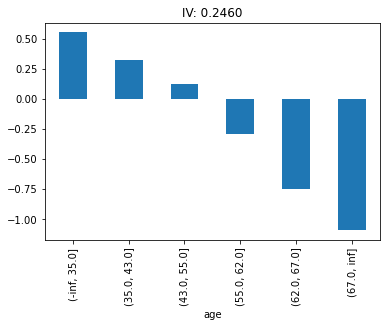

In [30]:
age_box,age_iv = chi2_box(df_train[['age','target']],50,.001)
display(age_box,age_box.woe.plot(kind='bar',title=f'IV: {age_iv:.4f}'))

target,0,1,p_val,woe
MonthlyIncome,,,,
"(-inf, 1300.0]",5245,375,7.194871e-08,-0.012929
"(1300.0, 3800.0]",24949,2429,3.027940e-04,0.295822
"(3800.0, 4550.0]",9873,826,7.191116e-03,0.144211
"(4550.0, 6311.2]",20301,1505,4.601453e-10,0.023298
"(6311.2, 10100.0]",25786,1513,3.250056e-07,-0.210562
"(10100.0, inf]",15645,725,1.000000e+00,-0.446559


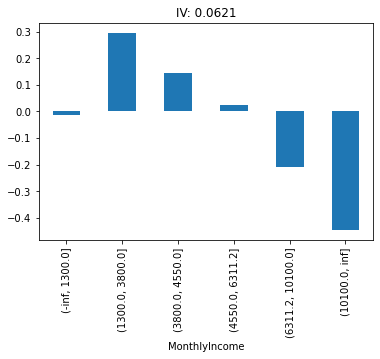

In [31]:
MI_box,MI_iv = chi2_box(df_train[['MonthlyIncome','target']],20,.01)
display(MI_box,MI_box.woe.plot(kind='bar',title=f'IV: {MI_iv:.4f}'))

target,0,1,p_val,woe
percentage,,,,
"(-inf, 0.00339]",10641,277,6.070287e-14,-1.023277
"(0.00339, 0.0452]",21533,301,1.087146e-06,-1.645056
"(0.0452, 0.118]",16044,331,8.670118e-09,-1.255796
"(0.118, 0.212]",10577,341,4.548459e-06,-0.809379
"(0.212, 0.357]",10448,469,1.222783e-06,-0.478387
"(0.357, 0.45]",5129,329,2.226469e-04,-0.121433
"(0.45, 0.563]",5032,427,9.426319e-05,0.158387
"(0.563, 0.7]",4915,543,3.118572e-10,0.422238
"(0.7, 0.85]",4703,756,5.227448e-20,0.797261


1.1419264530532993

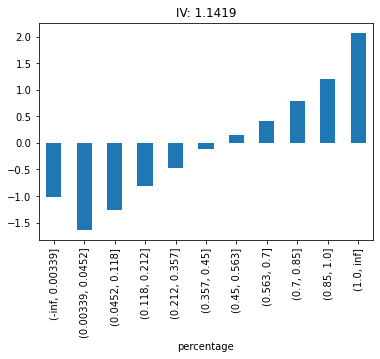

In [32]:
per_box,per_iv = chi2_box(df_train[['percentage','target']],20,.01)
display(per_box,per_iv,per_box.woe.plot(kind='bar',title=f'IV: {per_iv:.4f}'))

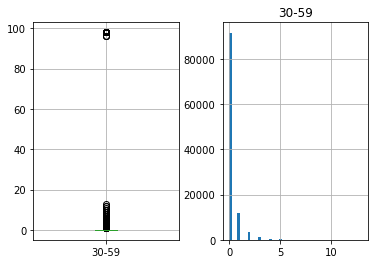

In [33]:
ax1 = plt.subplot(122)
df_train.loc[df_train['30-59'].lt(20),['30-59']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
df_train[['30-59']].boxplot(ax=ax2)

In [34]:
n30_box,n30_iv = chi2_box(df_train[['30-59','target']],20,.05)
display(n30_box,n30_iv) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
30-59,,,,
"(-inf, 1.0]",97833,5489,0.000000e+00,-0.255340
"(1.0, 2.0]",2511,903,6.963210e-29,1.602462
"(2.0, inf]",1455,981,1.000000e+00,2.230987


0.4769838370293407

target,0,1,woe
30-59,,,
"(-inf, 0.1]",87763,3707,-0.539241
"(0.1, 1.1]",10070,1782,0.893351
"(1.1, 2.1]",2511,903,1.602462
"(2.1, 3.1]",839,445,1.991039
"(3.1, 4.1]",316,234,2.324755
"(4.1, inf]",300,302,2.631820


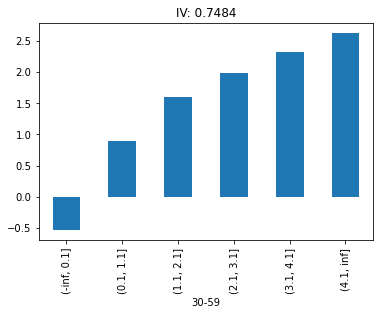

In [35]:
split = [-np.inf,.1,*np.arange(1.1,5,1),np.inf]
n30_box,n30_iv = init_box(df_train[['30-59','target']],split)
display(n30_box,n30_box.woe.plot(kind='bar',title=f'IV: {n30_iv:.4f}'))

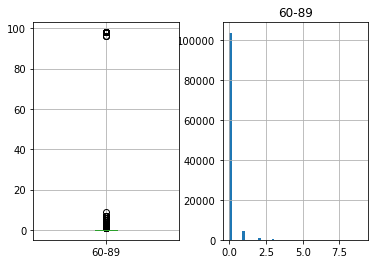

In [36]:
ax1 = plt.subplot(122)
df_train.loc[df_train['60-89'].lt(20),['60-89']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
df_train[['60-89']].boxplot(ax=ax2)

In [37]:
n60_box,n60_iv = chi2_box(data_train[['60-89','target']],20,.05)
display(n60_box,n60_iv) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
60-89,,,,
"(-inf, 1.0]",134899,8876,0.0,-0.096034
"(1.0, inf]",833,955,1.0,2.761819


0.2600777758140071

target,0,1,woe
60-89,,,
"(-inf, 0.1]",98237,5348,-0.285485
"(0.1, 1.1]",2935,1329,1.832895
"(1.1, 2.1]",419,394,2.563656
"(2.1, 3.1]",100,124,2.840287
"(3.1, 5.1]",40,59,3.013834
"(5.1, inf]",68,119,3.184791


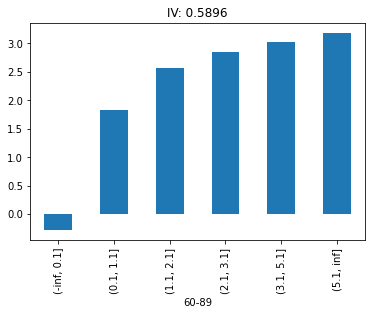

In [38]:
split = [-np.inf,.1,1.1, 2.1, 3.1,  5.1,np.inf]
n60_box,n60_iv = init_box(df_train[['60-89','target']],split)
display(n60_box,n60_box.woe.plot(kind='bar',title=f'IV: {n60_iv:.4f}'))

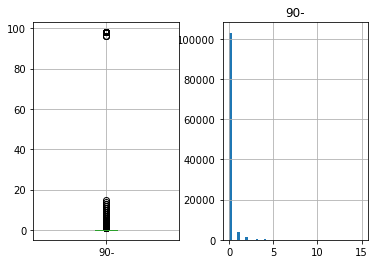

In [39]:
ax1 = plt.subplot(122)
df_train.loc[df_train['90-'].lt(20),['90-']].hist(ax=ax1,bins=50)
ax2=plt.subplot(121)
df_train[['90-']].boxplot(ax=ax2)

In [40]:
n90_box,n90_iv = chi2_box(data_train.loc[data_train.MonthlyIncome>1,['90-','target']],20,.05)
display(n90_box,n90_iv) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
90-,,,,
"(-inf, 1.0]",131844,8084,0.0,-0.174412
"(1.0, inf]",1310,1636,1.0,2.839548


0.4776358322593534

target,0,1,woe
90-,,,
"(-inf, 0.1]",98242,4803,-0.393017
"(0.1, 1.1]",2565,1329,1.967644
"(1.1, 2.1]",585,567,2.593923
"(2.1, 3.1]",203,276,2.932370
"(3.1, inf]",204,398,3.293508


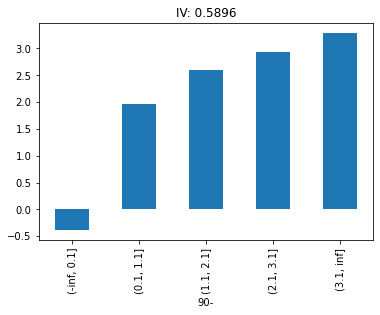

In [41]:
split = [-np.inf,.1,*np.arange(1.1,4,1),np.inf]
n90_box,n90_iv = init_box(df_train[['90-','target']],split)
display(n90_box,n90_box.woe.plot(kind='bar',title=f'IV: {n60_iv:.4f}')) ## 每箱数量差别太大，改手动分箱。

target,0,1,p_val,woe
DebtRatio,,,,
"(-inf, 0.00321]",4080,287,8.591365e-08,-0.029194
"(0.00321, 0.0167]",4192,175,2.655260e-10,-0.550972
"(0.0167, 0.226]",24502,1699,4.411517e-09,-0.043539
"(0.226, 0.344]",16572,896,1.956006e-10,-0.292354
"(0.344, 0.505]",16290,1177,1.021927e-09,-0.002407
"(0.505, 0.664]",7963,772,5.942830e-10,0.291599
"(0.664, 1.386]",7712,1020,3.450099e-21,0.602201
"(1.386, 701.0]",8084,653,5.910885e-11,0.109111
"(701.0, inf]",12404,694,1.000000e+00,-0.258127


0.07572269360659648

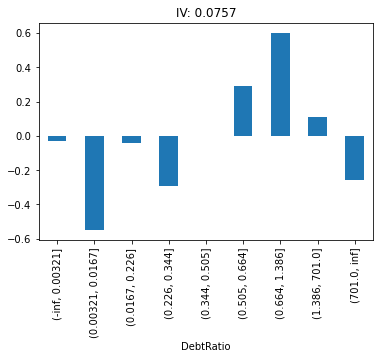

In [42]:
debt_box,debt_iv = chi2_box(df_train.loc[:,['DebtRatio','target']],25,.001)
display(debt_box,debt_iv)
debt_box.woe.plot(kind='bar',title=f'IV: {debt_iv:.4f}') ## 效果差，用手动分箱

D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
D:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
D:\Program Files\Anaconda3\lib\site-packages\pandas\plottin

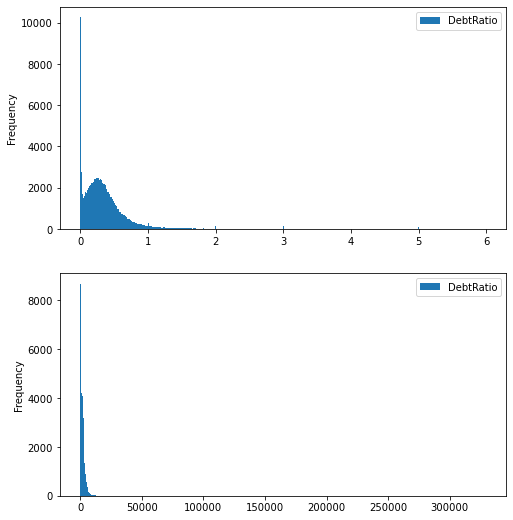

In [43]:
ax1 = plt.subplot(211)
data_train.query('6>DebtRatio')[['DebtRatio']].plot(kind='hist',ax=ax1, bins=500,figsize=(8,9))
## 0.04之前有异常，单独分一个箱
ax2 = plt.subplot(212)
data_train.query('6<=DebtRatio')[['DebtRatio']].plot(kind='hist',ax=ax2, bins=500,figsize=(8,9))
## 后面是一个长尾分布

target,0,1,woe
DebtRatio,,,
"(-inf, 0.08]",14558,944,-0.110594
"(0.08, 0.2]",14569,994,-0.059738
"(0.2, 0.3]",14255,789,-0.268921
"(0.3, 0.4]",12806,784,-0.168084
"(0.4, 0.5]",9123,700,0.057702
"(0.5, 0.6]",5716,541,0.267570
"(0.6, 0.7]",3712,379,0.343386
"(0.7, 0.8]",2255,284,0.553245
"(0.8, 0.9]",1461,193,0.600989


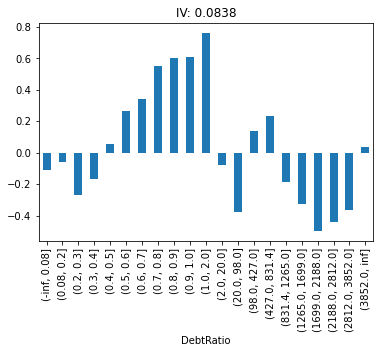

In [44]:
## 尝试多种分箱方法后的结果：
split = [-np.inf,.08,*np.arange(.2,1.1,.1),]
split2 = df_train.DebtRatio[data_train.DebtRatio.gt(2)].quantile(np.arange(10)/10).tolist()
b=split+split2+[np.inf]
debt_box,debt_iv = init_box(df_train.loc[:,['DebtRatio','target']],b)
# debt_box,debt_iv = init_box(data_train.loc[:,['DebtRatio','target']],b)
# debt_box,debt_iv = spearman_box(data_train.loc[:,['DebtRatio','target']],r_thr=.5)
display(debt_box)
debt_box.woe.plot(kind='bar',title=f'IV: {debt_iv:.4f}')

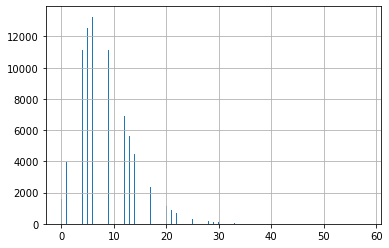

In [45]:
data_train.open_loan.hist(bins=500)

target,0,1,p_val,woe
open_loan,,,,
"(-inf, 2.0]",7619,1214,1.071438e-32,0.788451
"(2.0, 3.0]",5917,486,3.308424e-03,0.125799
"(3.0, 5.0]",16539,1152,4.193887e-04,-0.039046
"(5.0, 7.0]",18586,1111,1.402500e-02,-0.191972
"(7.0, 8.0]",8813,458,1.964331e-04,-0.331938
"(8.0, 12.0]",25116,1598,1.809791e-02,-0.129577
"(12.0, 13.0]",3978,212,8.180599e-06,-0.306773
"(13.0, inf]",15231,1142,1.000000e+00,0.034624


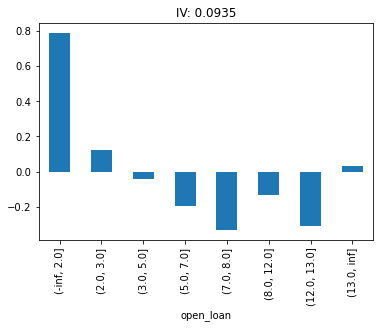

In [46]:
# loan_box,loan_iv = init_box(data_train.loc[:,['open_loan','target']],np.arange(15))
# loan_box,loan_iv = spearman_box(data_train.loc[:,['open_loan','target']],r_thr=.1)
loan_box,loan_iv = chi2_box(df_train.loc[:,['open_loan','target']])
display(loan_box)
loan_box.woe.plot(kind='bar',title=f'IV: {loan_iv:.4f}')

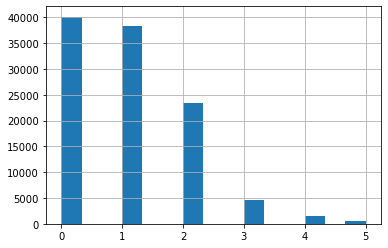

In [47]:
df_train.query('estate_loan<6').estate_loan.hist(bins=15)

target,0,1,woe
estate_loan,,,
"(-inf, 0.0]",36680,3424,0.253753
"(0.0, 1.0]",36268,2035,-0.255264
"(1.0, 2.0]",22081,1308,-0.201043
"(2.0, 3.0]",4369,308,-0.027014
"(3.0, 5.0]",1911,192,0.327289
"(5.0, inf]",490,106,1.094209


0.06771504740315935

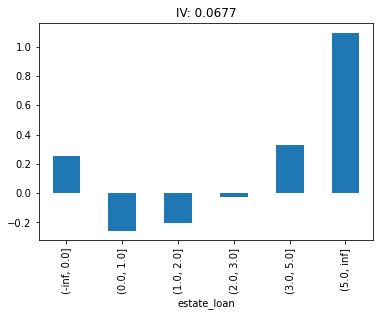

In [48]:
estate_box,estate_iv = init_box(df_train[['estate_loan','target']],
                               n_split = [-np.inf, 0, 1, 2, 3, 5, np.inf])
# estate_box,estate_iv = spearman_box(data_train[['estate_loan','target']],r_thr=.05)
display(estate_box,estate_iv)
estate_box.woe.plot(kind='bar',title=f'IV: {estate_iv:.4f}')

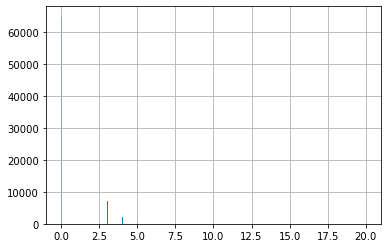

In [49]:
df_train.Dependents.hist(bins=500)

target,0,1,woe
Dependents,,,
"(-inf, 0.0]",60865,3853,-0.134631
"(0.0, 1.0]",18243,1434,0.081862
"(1.0, 2.0]",13552,1180,0.184156
"(2.0, 3.0]",6533,624,0.276704
"(3.0, 5.0]",2449,258,0.374700
"(5.0, inf]",157,24,0.746984


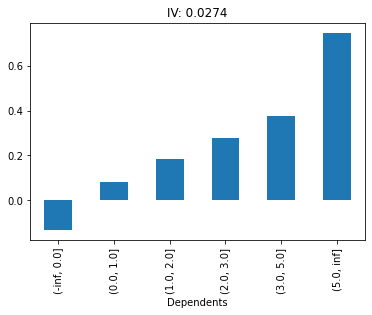

In [50]:
depend_box,depend_iv = init_box(df_train[['Dependents','target']],
                               n_split = [-np.inf, 0, 1, 2, 3, 5, np.inf])
# depend_box,depend_iv = chi2_box(data_train[['Dependents','target']])
display(depend_box)
depend_box.woe.plot(kind='bar',title=f'IV: {depend_iv:.4f}')

## WOE替换

In [51]:
woe_map = { 'percentage':per_box,
            'age':age_box,
            '30-59':n30_box,
            'DebtRatio':debt_box,
            'MonthlyIncome':MI_box,
            'open_loan':loan_box,
            '90-':n90_box,
            'estate_loan':estate_box,
            '60-89':n60_box,
            'Dependents':depend_box}
def woe_swag(df,woe=woe_map):
    df2={k:v.loc[df[k],'woe'].reset_index(drop=True) for k,v in woe.items()}
    df2['target'] = df.target.reset_index(drop=True)
    return pd.DataFrame(df2)

In [52]:
## 替换变量
data_train_bak = df_train.copy()
# data_train = data_train_bak.copy()

In [53]:
df_train = woe_swag(df_train)

In [54]:
df_train.head()

,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents,target
0,1.204158,0.552320,0.893351,-0.168084,0.023298,-0.039046,-0.393017,-0.255264,-0.285485,-0.134631,0
1,-1.255796,0.127063,-0.539241,-0.059738,0.295822,-0.039046,-0.393017,-0.255264,-0.285485,-0.134631,0
2,-0.809379,0.127063,-0.539241,0.267570,-0.446559,0.034624,-0.393017,0.327289,-0.285485,0.184156,0
3,-0.478387,0.127063,-0.539241,-0.268921,-0.210562,-0.331938,-0.393017,-0.201043,-0.285485,0.184156,0
4,-1.645056,-1.093561,-0.539241,-0.110594,0.295822,-0.039046,-0.393017,0.253753,-0.285485,-0.134631,0


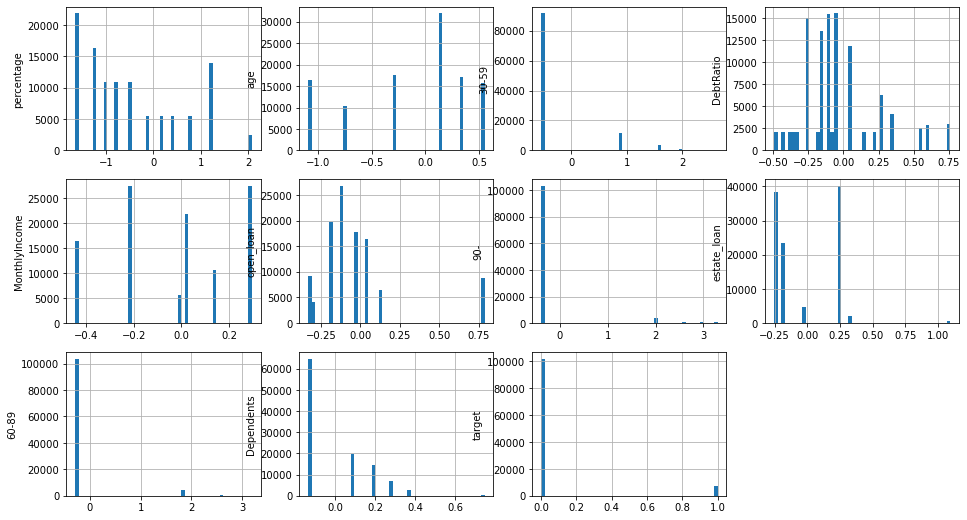

In [55]:
plt.figure(figsize=(16,9))
for i,col in enumerate(df_train.columns):
    plt.subplot(3,4,i+1)
    df_train[col].hist(bins=50)
    plt.ylabel(col)

In [56]:
df_test = woe_swag(df_test)

In [97]:
## 将正负样本SMOTE
# X, y = df_train.iloc[:,:-1].values, df_train.iloc[:,-1:].values
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=.5,n_jobs=-1)
X, y = smote.fit_resample(df_train.iloc[:,:-1], df_train.iloc[:,-1])

## 模型训练

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
my_scorer = make_scorer(roc_auc_score,needs_proba=True)
from sklearn.metrics import plot_roc_curve

In [95]:
# ss = StandardScaler()
# ss.fit(df_train.iloc[:,:-1])
# X = ss.fit_transform(X)
# X_test = ss.transform(X_test)

In [98]:
params = {'C':[.0005,.001,.01,.015,.02]}
lr = LogisticRegression(solver='liblinear')
clf = GridSearchCV(lr,params,n_jobs=-1,scoring=my_scorer)
clf.fit(X,y)

GridSearchCV(estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.0005, 0.001, 0.01, 0.015, 0.02]},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [148]:
display(clf.best_score_, clf.best_params_)

0.8603445930918546

{'C': 0.01}

0.855005107825436

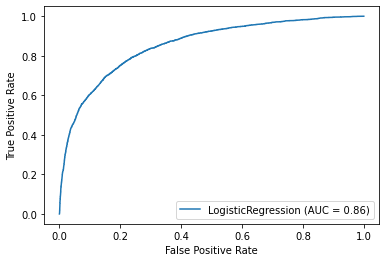

In [149]:
## 模型评估--auc
_ = plot_roc_curve(clf.best_estimator_,df_test.iloc[:,:-1],df_test.target.values)
roc_auc_score(df_test.target.values, clf.best_estimator_.predict_proba(df_test.iloc[:,:-1])[:,1])

In [103]:
from xgboost import XGBClassifier

0.8532204022299531

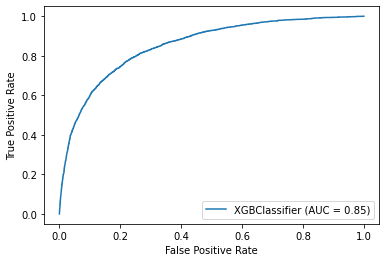

In [136]:
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X,y)
_ = plot_roc_curve(xgb,df_test.iloc[:,:-1],df_test.target.values)
roc_auc_score(df_test.target.values, xgb.predict_proba(df_test.iloc[:,:-1])[:,1])

In [137]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [144]:
rf = RandomForestClassifier()
params2 = {'max_depth':[3,5,7],'min_samples_leaf':[1,10,20]}
clf2 = GridSearchCV(rf,params2,scoring=my_scorer,n_jobs=-1)
clf2.fit(X,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_leaf': [1, 10, 20]},
             scoring=make_scorer(roc_auc_score, needs_proba=True),
             verbose=True)

In [146]:
print(clf2.best_params_,clf2.best_score_)

{'max_depth': 7, 'min_samples_leaf': 1} 0.9147483949260028


0.852461691788804

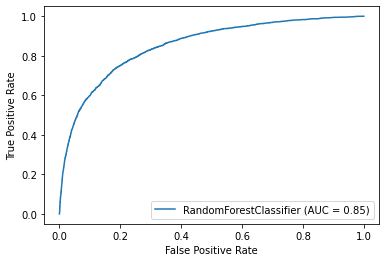

In [147]:
## 模型评估--auc
_ = plot_roc_curve(clf2.best_estimator_,df_test.iloc[:,:-1],df_test.target.values)
roc_auc_score(df_test.target.values, clf2.best_estimator_.predict_proba(df_test.iloc[:,:-1])[:,1])

In [177]:
clf_t = VotingClassifier([('lr',clf.best_estimator_),
                          ('xgb',xgb),
                          ('rf',clf2.best_estimator_)],voting='soft',weights=[3.5,4.5,2])
clf_t.fit(X,y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.01, solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=-1,
                                            num_pa

0.8577483204890162

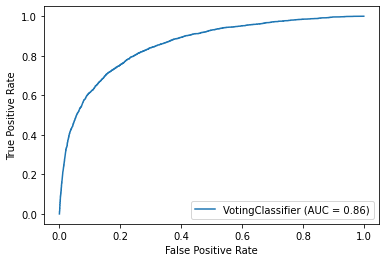

In [178]:
## 模型评估--auc
_ = plot_roc_curve(clf_t,df_test.iloc[:,:-1],df_test.target.values)
roc_auc_score(df_test.target.values, clf_t.predict_proba(df_test.iloc[:,:-1])[:,1])

## 预测结果

In [153]:
data_test.rename(columns=col_replace,inplace=True)

In [154]:
## 准备测试集
data_test.isna().sum()

target           101503
percentage            0
age                   0
30-59                 0
DebtRatio             0
MonthlyIncome     20103
open_loan             0
90-                   0
estate_loan           0
60-89                 0
Dependents         2626
dtype: int64

In [158]:
fill_len = data_test.Dependents.isna().sum()
data_test.loc[data_test.Dependents.isna(),'Dependents']=\
np.random.choice(data_train.loc[data_train.Dependents.notna(),'Dependents'],fill_len,False)

In [159]:
fill_len = data_test.MonthlyIncome.isna().sum()
data_test.loc[data_test.MonthlyIncome.isna(),'MonthlyIncome']=\
np.random.choice(data_train.loc[data_train.MonthlyIncome.notna(),'MonthlyIncome'],fill_len,False)

In [160]:
data_test2 = woe_swag(data_test)

In [161]:
data_test2.head()

,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents,target
0,1.204158,0.323744,-0.539241,-0.059738,0.023298,-0.039046,-0.393017,0.253753,-0.285485,-0.134631,NaN
1,0.158387,-0.291692,-0.539241,0.267570,-0.210562,0.034624,-0.393017,0.327289,-0.285485,0.184156,NaN
2,-1.645056,-0.291692,-0.539241,0.343386,0.023298,-0.129577,-0.393017,-0.255264,-0.285485,0.184156,NaN
3,-0.478387,0.323744,0.893351,0.608038,0.295822,-0.191972,-0.393017,-0.201043,-0.285485,-0.134631,NaN
4,1.204158,0.552320,-0.539241,-0.110594,0.144211,-0.039046,-0.393017,0.253753,-0.285485,0.081862,NaN


In [162]:
data_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
percentage       101503 non-null float64
age              101503 non-null float64
30-59            101503 non-null float64
DebtRatio        101503 non-null float64
MonthlyIncome    101503 non-null float64
open_loan        101503 non-null float64
90-              101503 non-null float64
estate_loan      101503 non-null float64
60-89            101503 non-null float64
Dependents       101503 non-null float64
target           0 non-null float64
dtypes: float64(11)
memory usage: 8.5 MB


In [180]:
y_hat = clf_t.predict_proba(data_test2.iloc[:,:-1])[:,1]

In [182]:
to_push = pd.DataFrame({'Id':data_test.index.tolist(),
                        'Probability':y_hat})
to_push.to_csv('submission.csv', index=False)

In [183]:
to_push.head()

,Id,Probability
0,1,0.265402
1,2,0.152029
2,3,0.053243
3,4,0.233310
4,5,0.335554


## 模型评估--psi

In [101]:
def PSI(model, X_train,X_test):
    '''
    训练集样本分箱频率统计与待预测样本分箱频率统计的KL散度求和
    '''
    bins = np.arange(11)/10.0
    
    y_train = model.predict_proba(X_train)[:,1]
    train_count = pd.value_counts(y_train,sort=False,bins=bins,normalize=True)
    
    y_test = model.predict_proba(X_test)[:,1]
    test_count = pd.value_counts(y_test,sort=False,bins=bins,normalize=True)
    
    return (train_count-test_count).dot(np.log(train_count/test_count))

In [188]:
## data_test3是下面计算结果，这里提前用一下
psi=PSI(clf_t, df_train.iloc[:,:-1], data_test2.iloc[:,:-1])*100
print(f'PSI= {psi:.4f}%, 低于10%, 模型稳定。')

PSI= 0.0272%, 低于10%, 模型稳定。


## 评分规则建立

In [184]:
## 确定阈值--KS检验
def KS(model, X, y):
    y_prob = model.predict_proba(X)[:,1]
    df = pd.DataFrame(roc_curve(y, y_prob),index=['fpr','tpr','thre']).T
    df['gap'] = df.tpr - df.fpr
    ks = df.gap.max()
    fpr_max, tpr_max, thre, _  = df.loc[df.gap.idxmax(),:]
    
    df.plot(x='thre',y=['fpr','tpr'],xlim=(0,1),
           title=f'KS: {ks:.4f}, thre: {thre:.4f}')
    plt.vlines(thre,fpr_max,tpr_max,color='r')
    
    return thre

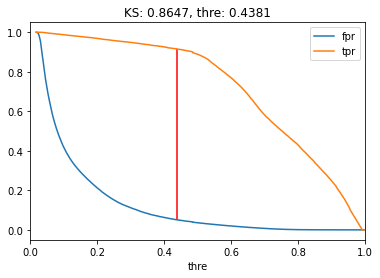

In [185]:
thre = KS(clf_t, X, y)

In [186]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit([[thre], [1]],[60,100])
print(f'y = {lr.coef_[0]:.4f} * X + {lr.intercept_:.4f}')

y = 71.1897 * X + 28.8103
